In [1]:
import numpy as np
from keras import Sequential
from keras.datasets.mnist import load_data
from keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Conv2DTranspose
from keras.optimizers import Adam
from matplotlib import pyplot
from numpy import zeros, ones, vstack, expand_dims
from numpy.random import randn, randint

In [2]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype(('float32'))
    X = X / 255.0
    return X
trainX = load_real_samples()

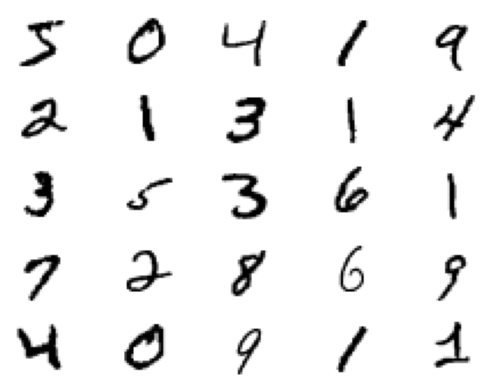

In [3]:
for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(trainX[i], cmap='gray_r')

In [4]:
def define_disc(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

In [5]:
model = define_disc()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [6]:
def define_gen(latent_dim):
    model = Sequential()
    model.add(Dense(128*7*7, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

In [7]:
gen_model = define_gen(100)
gen_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

In [8]:
def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [9]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [10]:
def generate_real_samples(n_samples):
   ix = randint(0, trainX.shape[0], n_samples)
   X = trainX[ix]
   y = ones((n_samples, 1))
   return X, y


1/1 [==============================] - 1s 582ms/step


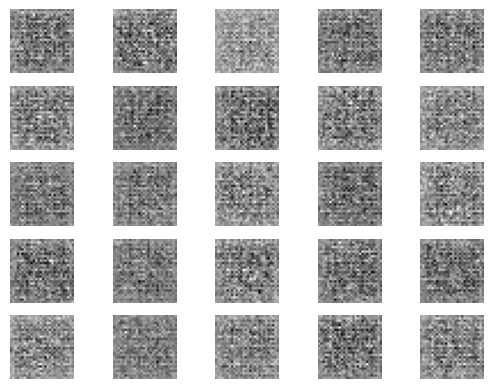

In [11]:
generatedX, _ = generate_fake_samples(gen_model, 100, 25)
for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(generatedX[i, :, :, 0], cmap='gray_r')

In [12]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

In [13]:
def train_gan(g_model, d_model, gan_model, latent_dim, epochs=100, batch_size=256):
    batch_per_epo = int(trainX.shape[0] / batch_size)
    half_batch = int(batch_per_epo / 2)
    for i in range(epochs):
        if i+i%5 == 0:
            summarize_performance(i,g_model,d_model,latent_dim)
        for j in range(batch_per_epo):
            realX, realy = generate_real_samples(half_batch)
            fakeX, fakey = generate_fake_samples(g_model, 100, half_batch)
            X, y = vstack((realX, fakeX)), vstack((realy, fakey))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, batch_size)
            y_gan = ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epo, d_loss, g_loss))

In [14]:
def summarize_performance(epoch, g_model, d_model, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'saved/generator_model_%03d.h5' % (epoch + 1)
    save_plot(X_fake, epoch + 1)
    g_model.save(filename)

In [15]:
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
        filename = 'saved/generated_plot_e%03d.png' % (epoch + 1)
        pyplot.savefig(filename)
        pyplot.close()

In [ ]:
latent_dim = 100
d_model = define_disc()
g_model = define_gen(latent_dim)
gan_model = define_gan(g_model, d_model)
train_gan(g_model, d_model, gan_model, latent_dim)

4/4 [==============================] - 0s 69ms/step
>Accuracy real: 36%, fake: 100%
4/4 [==============================] - 0s 105ms/step
>1, 1/234, d=0.692, g=0.712
4/4 [==============================] - 0s 104ms/step
>1, 2/234, d=0.686, g=0.728
4/4 [==============================] - 0s 102ms/step
>1, 3/234, d=0.680, g=0.739
4/4 [==============================] - 0s 105ms/step
>1, 4/234, d=0.673, g=0.752
4/4 [==============================] - 0s 102ms/step
>1, 5/234, d=0.670, g=0.769
4/4 [==============================] - 0s 106ms/step
>1, 6/234, d=0.665, g=0.777
4/4 [==============================] - 0s 108ms/step
>1, 7/234, d=0.658, g=0.791
4/4 [==============================] - 0s 102ms/step
>1, 8/234, d=0.651, g=0.800
4/4 [==============================] - 0s 78ms/step
>1, 9/234, d=0.647, g=0.804
4/4 [==============================] - 0s 104ms/step
>1, 10/234, d=0.645, g=0.806
4/4 [==============================] - 0s 103ms/step
>1, 11/234, d=0.643, g=0.799
4/4 [===================